In [1]:
from statsmodels.tsa.statespace.varmax import VARMAX

import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

We have app data that for each user pairs reported app metrics and app name:

In [2]:
appDf = pd.read_csv("app.data", names=["user", "date", "app", "metric"])
appDf['date'] = pd.to_datetime(appDf['date'])
appDf.info()
print(appDf.user.unique(), appDf.app.unique())
appDf.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1316 entries, 0 to 1315
Data columns (total 4 columns):
user      1316 non-null object
date      1316 non-null datetime64[ns]
app       1316 non-null object
metric    1316 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 41.2+ KB
['user_1' 'user_3' 'user_2'] [' app_2' ' app_3' ' app_1']


user                date     app  metric
0  user_1 2017-08-28 14:26:20   app_2    0.02
1  user_3 2017-08-28 18:40:12   app_3    0.00
2  user_1 2017-08-28 20:21:54   app_1    0.01
3  user_3 2017-08-29 00:20:48   app_1    0.00
4  user_2 2017-08-29 08:46:42   app_2    0.10

We have location data that uses keywords for location and indicates a change of location:

In [3]:
locationDf = pd.read_csv("location.data", names=["user", "date", "location"])
locationDf['date'] = pd.to_datetime(locationDf['date'])

cross_l = pd.crosstab([locationDf.date, locationDf.user], locationDf.location)

cross_l.head(3)

location                     bar   girlfriends   grocers   home   lunch  \
date                user                                                  
2017-08-28 00:00:01 user_2     0             0         0      1       0   
                    user_3     0             0         0      1       0   
2017-08-28 15:02:29 user_2     0             1         0      0       0   

location                     park   relatives   work  
date                user                              
2017-08-28 00:00:01 user_2      0           0      0  
                    user_3      0           0      0  
2017-08-28 15:02:29 user_2      0           0      0

Location data includes seasonality at actual seasonal levels (summer, winter), as well as weekday/weekend behavior. Here this is demonstrated with cumsum:

'User/Locations'

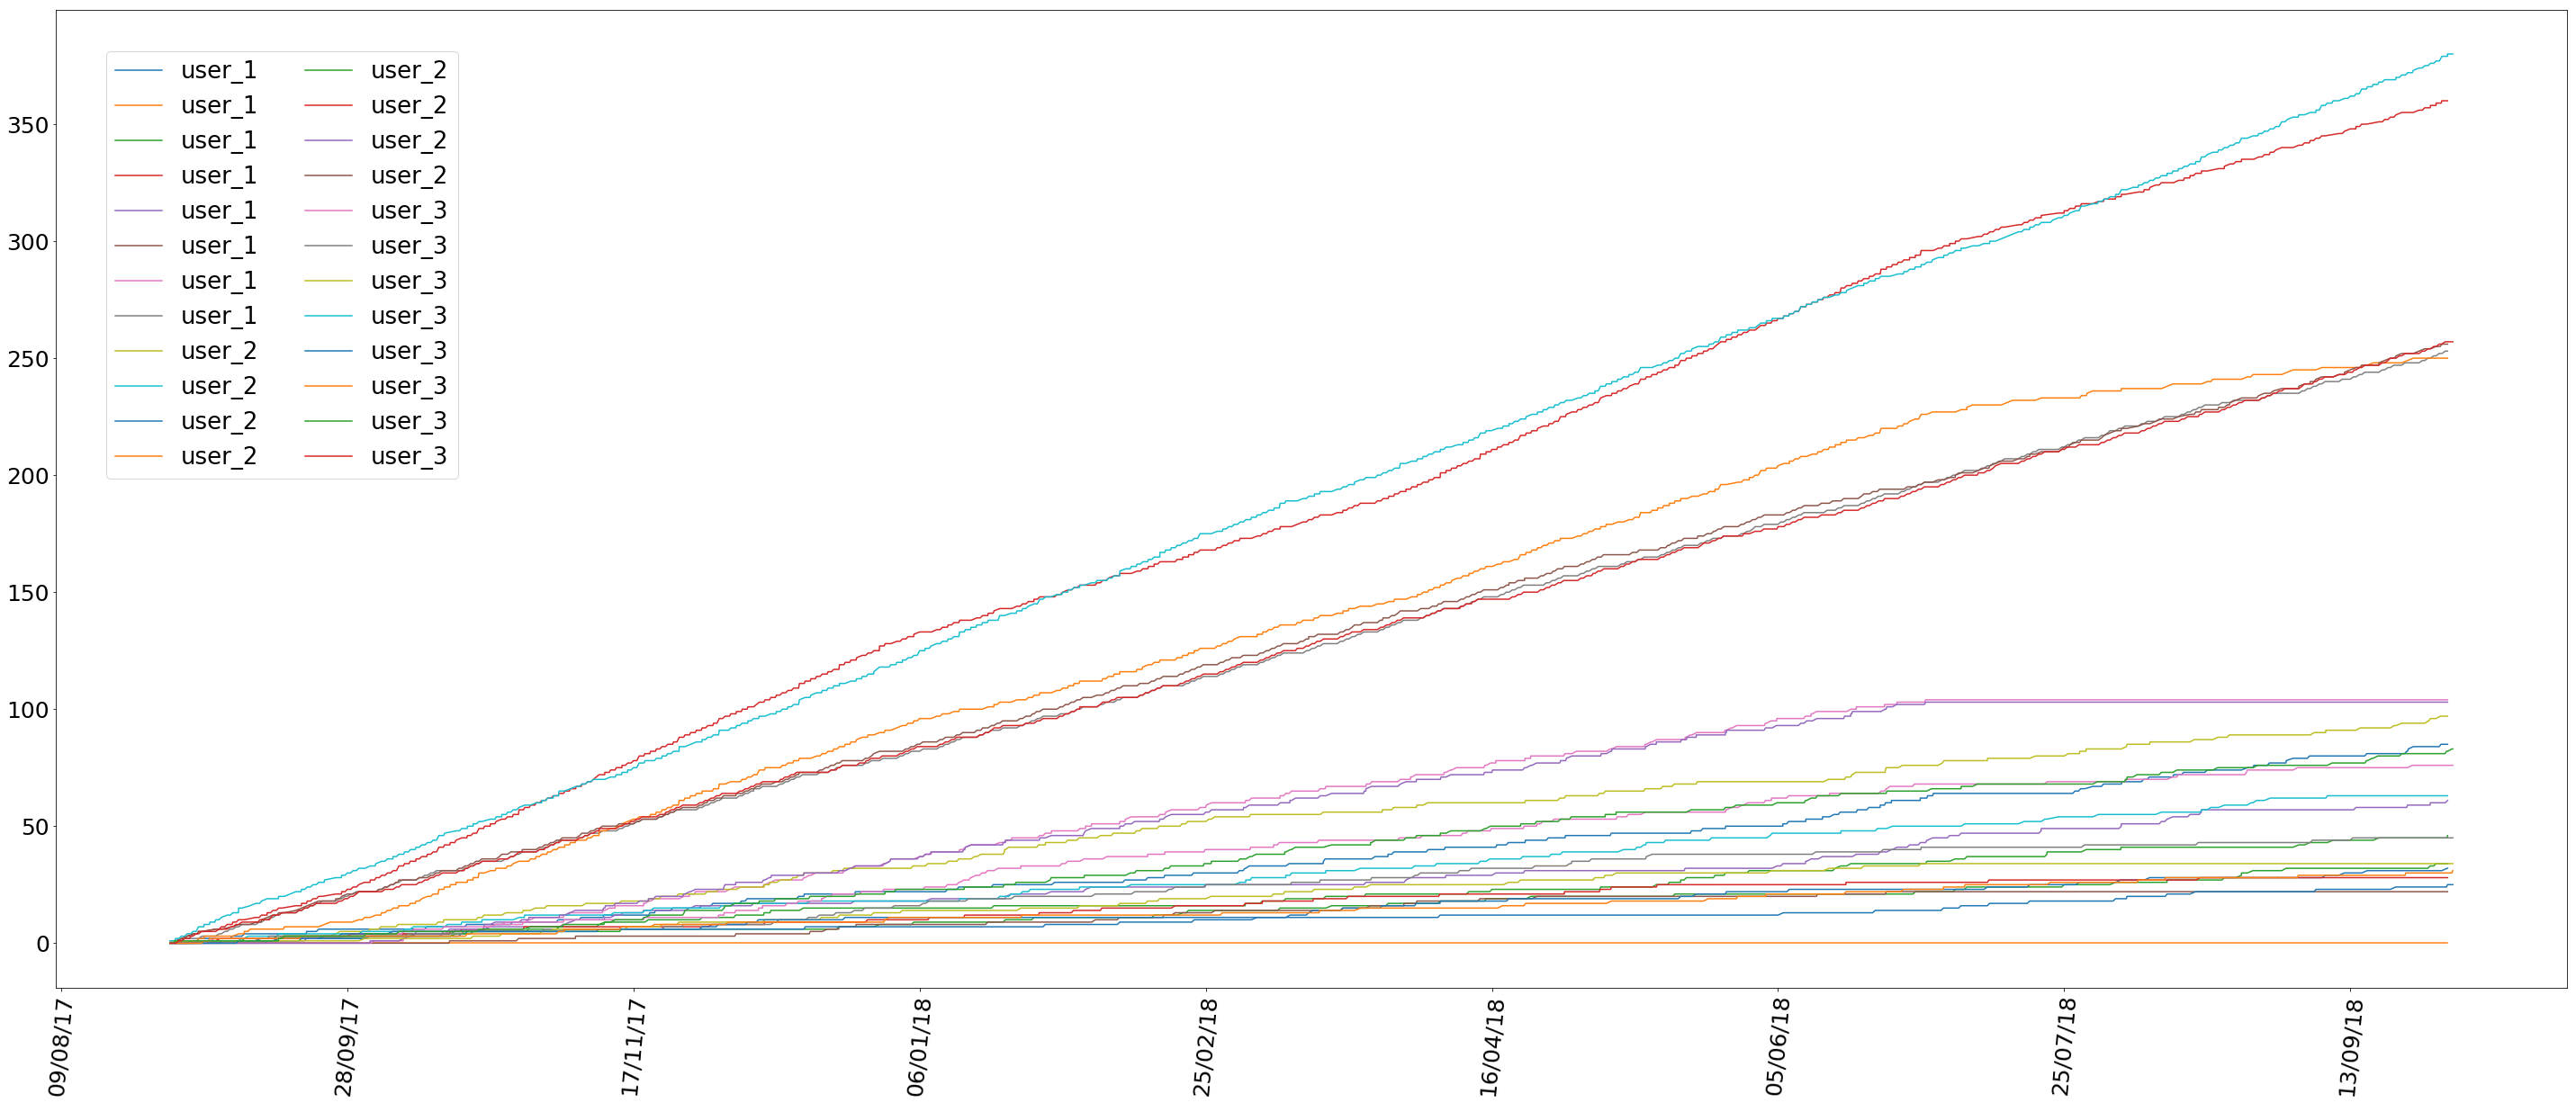

In [4]:
cross = cross_l.copy()

l2 = cross.groupby(['user']).cumsum().copy()
l2.reset_index(inplace=True)

plotaxis = plt.figure(figsize=(50,20)).gca()
for key, grp in l2.groupby(['user']):
    my_ts = [ts.to_julian_date() - 1721424.5 for ts in grp['date']]
    plt.plot(my_ts, grp.drop('user', axis=1).drop('date', axis=1), label=key)

plotaxis.xaxis.set_major_formatter(
    matplotlib.dates.DateFormatter('%d/%m/%y')
)
xlabels = plotaxis.get_xticklabels()
plt.setp(xlabels, rotation=85, fontsize=25)
ylabels = plotaxis.get_yticklabels()
plt.setp(ylabels, fontsize=25)

plt.legend(bbox_to_anchor=(.02, 0.52, 1., .102), loc=3,
           ncol=2, borderaxespad=0., prop={'size': 26})    

#l3 = l2[l2['user'] == 'user_1'].copy()
#l3['month']=l3['date'].dt.month
#grouped = l3.groupby(l3['month'])
#
#for m in grouped.groups.keys():
#    print(l3[l3['month'] == m].tail(1))
#l2.groupby(['user']).sum()

'User/Locations'

The some metric data is set to have positive or negative correlation in terms of growth, to location data. Excluding seasonality, the metric data should trend upwards:

'Users/Apps'

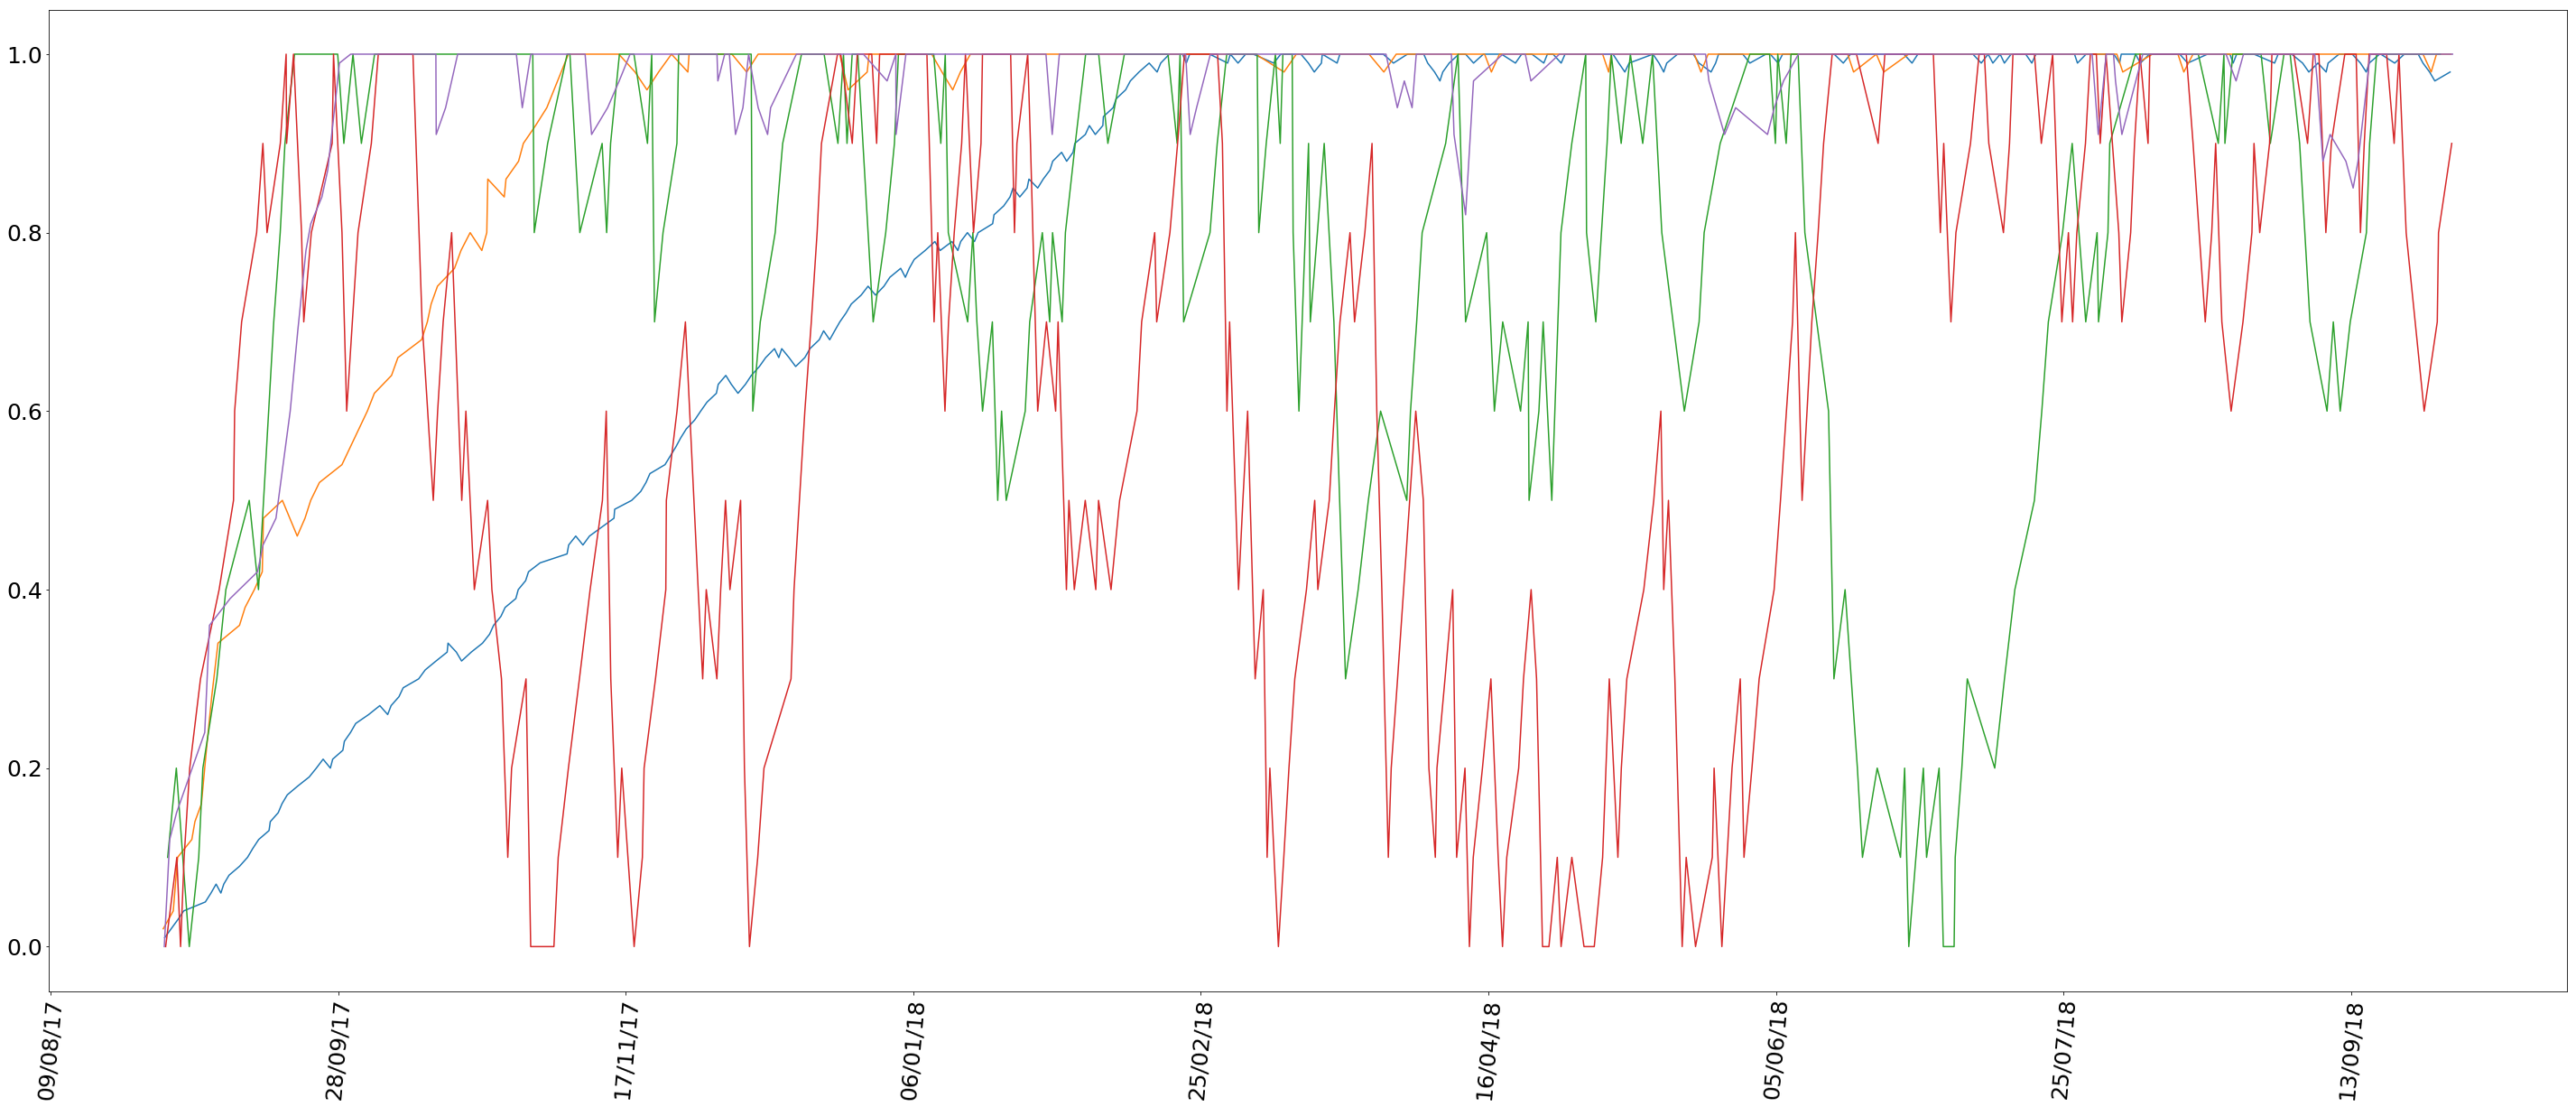

In [5]:
#appDf.groupby(['user', 'app']).plot(x="date", y="metric", subplots=True)

plotaxis = plt.figure(figsize=(50,20)).gca()
for key, grp in appDf.groupby(['user', 'app']):
    my_ts = [ts.to_julian_date() - 1721424.5 for ts in grp['date']]
    plt.plot(my_ts, grp['metric'], label='%s@%s' % ("metric", key))

plotaxis.xaxis.set_major_formatter(
    matplotlib.dates.DateFormatter('%d/%m/%y')
)
xlabels = plotaxis.get_xticklabels()
plt.setp(xlabels, rotation=85, fontsize=25)
ylabels = plotaxis.get_yticklabels()
plt.setp(ylabels, fontsize=25)
'Users/Apps'

Here we can see in fine detail user_1's metric trend and location data. Looking at the very beginning at increased zoom, you might notice a visual correlation between the first few gaps and the faster-rising app data.

True

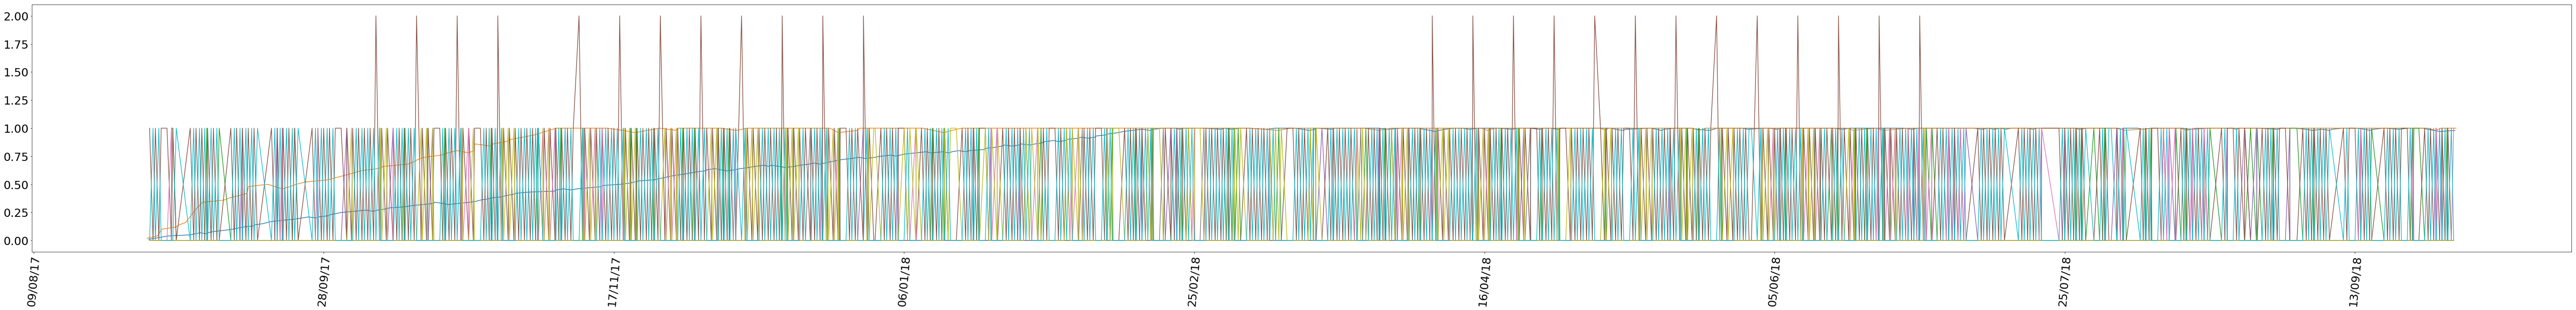

In [6]:
cross.reset_index(inplace=True)

u1_l = cross[cross['user'] == 'user_1']

u1_a = appDf[appDf['user'] == 'user_1']

u1_a1 = u1_a[u1_a['app'] == ' app_1']
u1_a2 = u1_a[u1_a['app'] == ' app_2']

plotaxis = plt.figure(figsize=(100,10)).gca()

for key, grp in u1_a.groupby(['app']):
    my_ts = [ts.to_julian_date() - 1721424.5 for ts in grp['date']]
    plt.plot(my_ts, grp['metric'], label='%s@%s' % ("metric", key))    

for key, grp in u1_l.groupby(['user']):
    my_ts = [ts.to_julian_date() - 1721424.5 for ts in grp['date']]
    plt.plot(my_ts, grp.drop('user', axis=1).drop('date', axis=1), label=key)
    
plotaxis.xaxis.set_major_formatter(
    matplotlib.dates.DateFormatter('%d/%m/%y')
)
xlabels = plotaxis.get_xticklabels()
plt.setp(xlabels, rotation=85, fontsize=25)
ylabels = plotaxis.get_yticklabels()
plt.setp(ylabels, fontsize=25)
True

We want to produce classical machine learning/statistical modeling as a baseline to justify RNN approaches. We will follow this strategy in preparation of an ARIMA model:

1. fill rows in both set by date, so the data sets can be combined.
2. 

In [10]:
appDf.setIndex('date', inplace=True)

appDfs = []
for user, a2_df in appDf.groupby('user'):
    appDfs.append(a2_df.resample('15T').agg('max').ffill())

locDf = locationDf.copy()
locDf.set_index('date', inplace=True)

locDfs = []
for user, user_loc_dc in locDf.groupby('user'):
    locDfs.append(user_loc_dc.resample('15T').agg('max').ffill())


#combDf = appDf.join(locDfGrp, how='outer')

# The 'MS' string groups the data in buckets by start of the month
#y = y['co2'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
#y = y.fillna(y.bfill())

                       user location
date                                
2017-08-29 00:00:00  user_1     home
2017-08-29 00:15:00  user_1     home
2017-08-29 00:30:00  user_1     home
2017-08-29 00:45:00  user_1     home
2017-08-29 01:00:00  user_1     home
2017-08-29 01:15:00  user_1     home
2017-08-29 01:30:00  user_1     home
2017-08-29 01:45:00  user_1     home
2017-08-29 02:00:00  user_1     home
2017-08-29 02:15:00  user_1     home
2017-08-29 02:30:00  user_1     home
2017-08-29 02:45:00  user_1     home
2017-08-29 03:00:00  user_1     home
2017-08-29 03:15:00  user_1     home
2017-08-29 03:30:00  user_1     home
2017-08-29 03:45:00  user_1     home
2017-08-29 04:00:00  user_1     home
2017-08-29 04:15:00  user_1     home
2017-08-29 04:30:00  user_1     home
2017-08-29 04:45:00  user_1     home
2017-08-29 05:00:00  user_1     home
2017-08-29 05:15:00  user_1     home
2017-08-29 05:30:00  user_1     home
2017-08-29 05:45:00  user_1     home
2017-08-29 06:00:00  user_1     home
2